Program for reconstructing holograms from a config file generated with $\mathtt{FTHreconstruction.ipynb}$. You can still change the beamstop size, the ROI and the propagation distance.

# Load libraries

Import the libraries. Execute this cell only once when the kernel is started.

In [1]:
# import self written libraries. These have to be in the same folder or the parent directory.
import sys, os
sys.path.append('./library/')
import fth_reconstruction as fth
from cameras import load_greateyes, load_spe
import reconstruct as rec

import numpy as np
import matplotlib.pyplot as plt

#interactive stuff
import ipywidgets as widgets
from IPython.display import display
import ipython_blocking

In [2]:
%matplotlib widget

# Load images

Input the image numbers, first the positive helicity image followed by the negative helicity image. If you want to do a single helicity reconstruction, then put $\mathtt{np.nan}$ into the spot, where no image is. Please specify which config file you want to use.

You must also specify whether you want to use an autofactor when substracting the images (or the topography when doing a single helicity reconstruction -- recomended!) and which parameters you want to change (propagation, ROI, beamstop). Just set the according values to True/False.

Input the file folders for the data, the matlab files and where the results are saved (check, if this is correct, especially when switching from Linux to Windows and vice versa!).

**You can execute the integrity of the following code with -> "Cell" -> "Run Cells Below". Some interaction is needed and the code will stop there and resume when you are finished.**

In [16]:
images = np.array([np.nan, 2310])
topo = np.array([2309, 2310])
conf_nr = 2309

beamtime = 1904

autoFactor = True
propagate = False
ROI = False
beamstop = False

# spe = 'holo_  '
spe = None

In [6]:
folder  = r'../testdata/'
folder_save_start = r'../processed/'
conf_folder = folder_save_start + '%i/'%conf_nr
 

Determine whether a double helicity or single helicity (positive or negative) is done

Load the images, add them up, shift the center.

Returns the shifted hologram, the center coordinates the beamstop diameter and the propagation distance from the config file.

In [17]:
if np.isnan(images[0]):
    image = images[1].astype(np.int)
    im = image
    hel = False
elif np.isnan(images[1]):
    image = images[0].astype(np.int)
    hel = True
    im = image
else:
    image = images.astype(np.int)
    hel = None
    im = image[0]
    
holo, factor, center, bs_diam, roi, prop_dist, phase = rec.fromParameters(folder, image, conf_folder + 'PETRA_P04_0620_%04d.hdf'%conf_nr, new_bs = beamstop, old_prop = not(propagate), topo_nr=topo, helpos=hel,
                                                                          auto_factor = autoFactor, spe_prefix = spe)

Single Helicity Reconstruction
Loaded image ../testdata/holo_2309.dat
Loaded image ../testdata/holo_2310.dat
Loaded image ../testdata/holo_2310.dat
Auto factor = 0.4982391268815898
Start reconstructing the image using the center and beamstop mask from the Matlab reconstruction.
Shifted image by -28 pixels in x and -40 pixels in y.
Using beamstop diameter 80 from config file and a sigma of 10.
Using propagation distance from config file.
Propagation distance: -1.87um
Now determine the global phase shift by executing phase_shift.


# Cosmic Rays

In [15]:
# fig, ax = plt.subplots(figsize = (8, 8))
# ax.imshow(np.abs(holo)>1000)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
# holo = remove_two(holo, [1126, 1127], 1888)

# holo = fth.remove_cosmic_ray(holo, [290, 642])

In [22]:
# holo = np.delete(holo, 68, axis = 1)
# holo = np.delete(holo, 0, axis = 0)

In [23]:
# holo[1851, 1941:1949] = holo[1852, 1941:1949]
# holo[1850, 1951:1960] = holo[1849, 1951:1960]

# Beamstop

You may change the beamstop diameter in the text widget below the following cell. The default value in the field is the beamstop diameter from the config file.

Click on the button when you are finished to resume the execution of the code. 

In [24]:
if beamstop:
    bs_input, bs_button = rec.change_beamstop(bs_diam)

In [25]:
if beamstop:    
    %block bs_button

In [26]:
if beamstop:
    bs_diam = bs_input.value
    holo = rec.set_beamstop(holo, bs_diam)

In [27]:
if np.logical_and(beamstop, not propagate):
    holo = fth.propagate(holo, prop_dist*1e-6)

# ROI

You may select the reconstruction you want to look at. Do this by zooming into the image and putting in the x and y coordinates of the start and end points of your ROI.

Click on the button when you are finished to resume the execution of the code. 

<IPython.core.display.Javascript object>


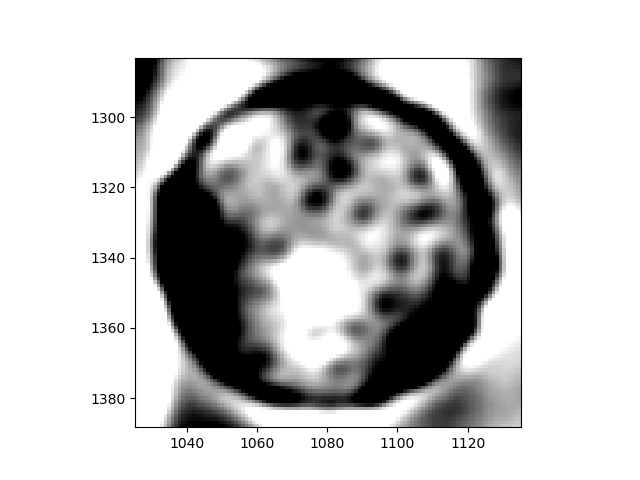

In [28]:
if ROI:
    fig, ax = fth.plot(np.real(fth.reconstruct(holo)), colorbar = False, scale = (2,98))

In [31]:
if ROI:
    x1, x2 = ax.get_xlim()
    y2, y1 = ax.get_ylim()
    roi = np.array([integer(x1), integer(x2), integer(y1), integer(y2)]) #xstart, xstop, ystart, ystop

# Propagate and Shift Phase

Now, the hologram can to be propagated. Use the slider "propagation" and chose a value for which the image is sharp.

Then you need to apply a global phase shift to the image, to get all the information into one part of the complex image (usually the real part).

Click on the button when you are finished to resume the execution of the code. 

In [18]:
if propagate:
    slider_prop, slider_phase, button = rec.propagate(holo, roi, phase, prop_dist)
else:
    slider_phase, button = rec.phase_shift(holo, roi, phase)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=2.09941, description='phase shift', layout=Layout(width='90%'), max=3.…

Button(description='Finished', style=ButtonStyle())

In [76]:
%block button

# Save

Save the reconstruction (only the selected ROI) as a numpy array and all the parameters in a config file.

In [27]:
folder_save = folder_save_start + '%04d//'%im

if not(os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)

Creating folder ../processed/2310//


In [21]:
if propagate:
    prop_dist=slider_prop.value

phase = slider_phase.value

recon = fth.reconstruct(fth.propagate(holo, prop_dist*1e-6)*np.exp(1j*phase))[roi[2]:roi[3], roi[0]:roi[1]]

Propagation distance: -1.87um


In [29]:
fig, ax = plt.subplots(frameon = False, figsize = (recon.shape[1] / 40, recon.shape[0] / 40))
ax.imshow(np.real(recon), cmap = 'gray')
ax.set_axis_off()
ax.annotate('%04d'%im, (.015, .95), xycoords = 'axes fraction', bbox = {'alpha': .5, 'ec': None, 'fc': 'w', 'lw': None})
plt.savefig(folder_save + 'PETRA_P04_0620_%04d.png'%im, bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
rec.save_parameters(folder_save + 'P04_0620_%04d.hdf'%im, recon, factor, center, bs_diam, prop_dist, phase, roi, images, comment = 'test reconstruction', topo = topo)